#1. Importação das Bibliotecas Necessárias

In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

#2. Criação do Conjunto de Dados Sintético

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

#3.Salvamento dos Dados Originais

In [3]:
data_original = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
data_original['Target'] = y
data_original.to_csv('data_original.csv', index=False)

#4.Padronização dos Dados

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#5.Salvamento dos Dados Padronizados

In [5]:
data_scaled = pd.DataFrame(X_scaled, columns=['Feature 1', 'Feature 2'])
data_scaled['Target'] = y
data_scaled.to_csv('data_scaled.csv', index=False)


#6. Divisão do Conjunto de Dados em Treino e Teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


#7. Treinamento do Algoritmo SVM com Diferentes Kernels

In [7]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    # Without scaling
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    # With scaling
    svm_scaled = SVC(kernel=kernel, probability=True, random_state=42)
    svm_scaled.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = svm_scaled.predict(X_test_scaled)

    # Evaluate performance
    results[kernel] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_curve': roc_curve(y_test, svm.predict_proba(X_test)[:, 1]),
        'auc': auc(roc_curve(y_test, svm.predict_proba(X_test)[:, 1])[0],
                   roc_curve(y_test, svm.predict_proba(X_test)[:, 1])[1]),
        'confusion_matrix_scaled': confusion_matrix(y_test_scaled, y_pred_scaled),
        'classification_report_scaled': classification_report(y_test_scaled, y_pred_scaled),
        'roc_curve_scaled': roc_curve(y_test_scaled, svm_scaled.predict_proba(X_test_scaled)[:, 1]),
        'auc_scaled': auc(roc_curve(y_test_scaled, svm_scaled.predict_proba(X_test_scaled)[:, 1])[0],
                          roc_curve(y_test_scaled, svm_scaled.predict_proba(X_test_scaled)[:, 1])[1])
    }


#8. Plotagem das Fronteiras de Decisão

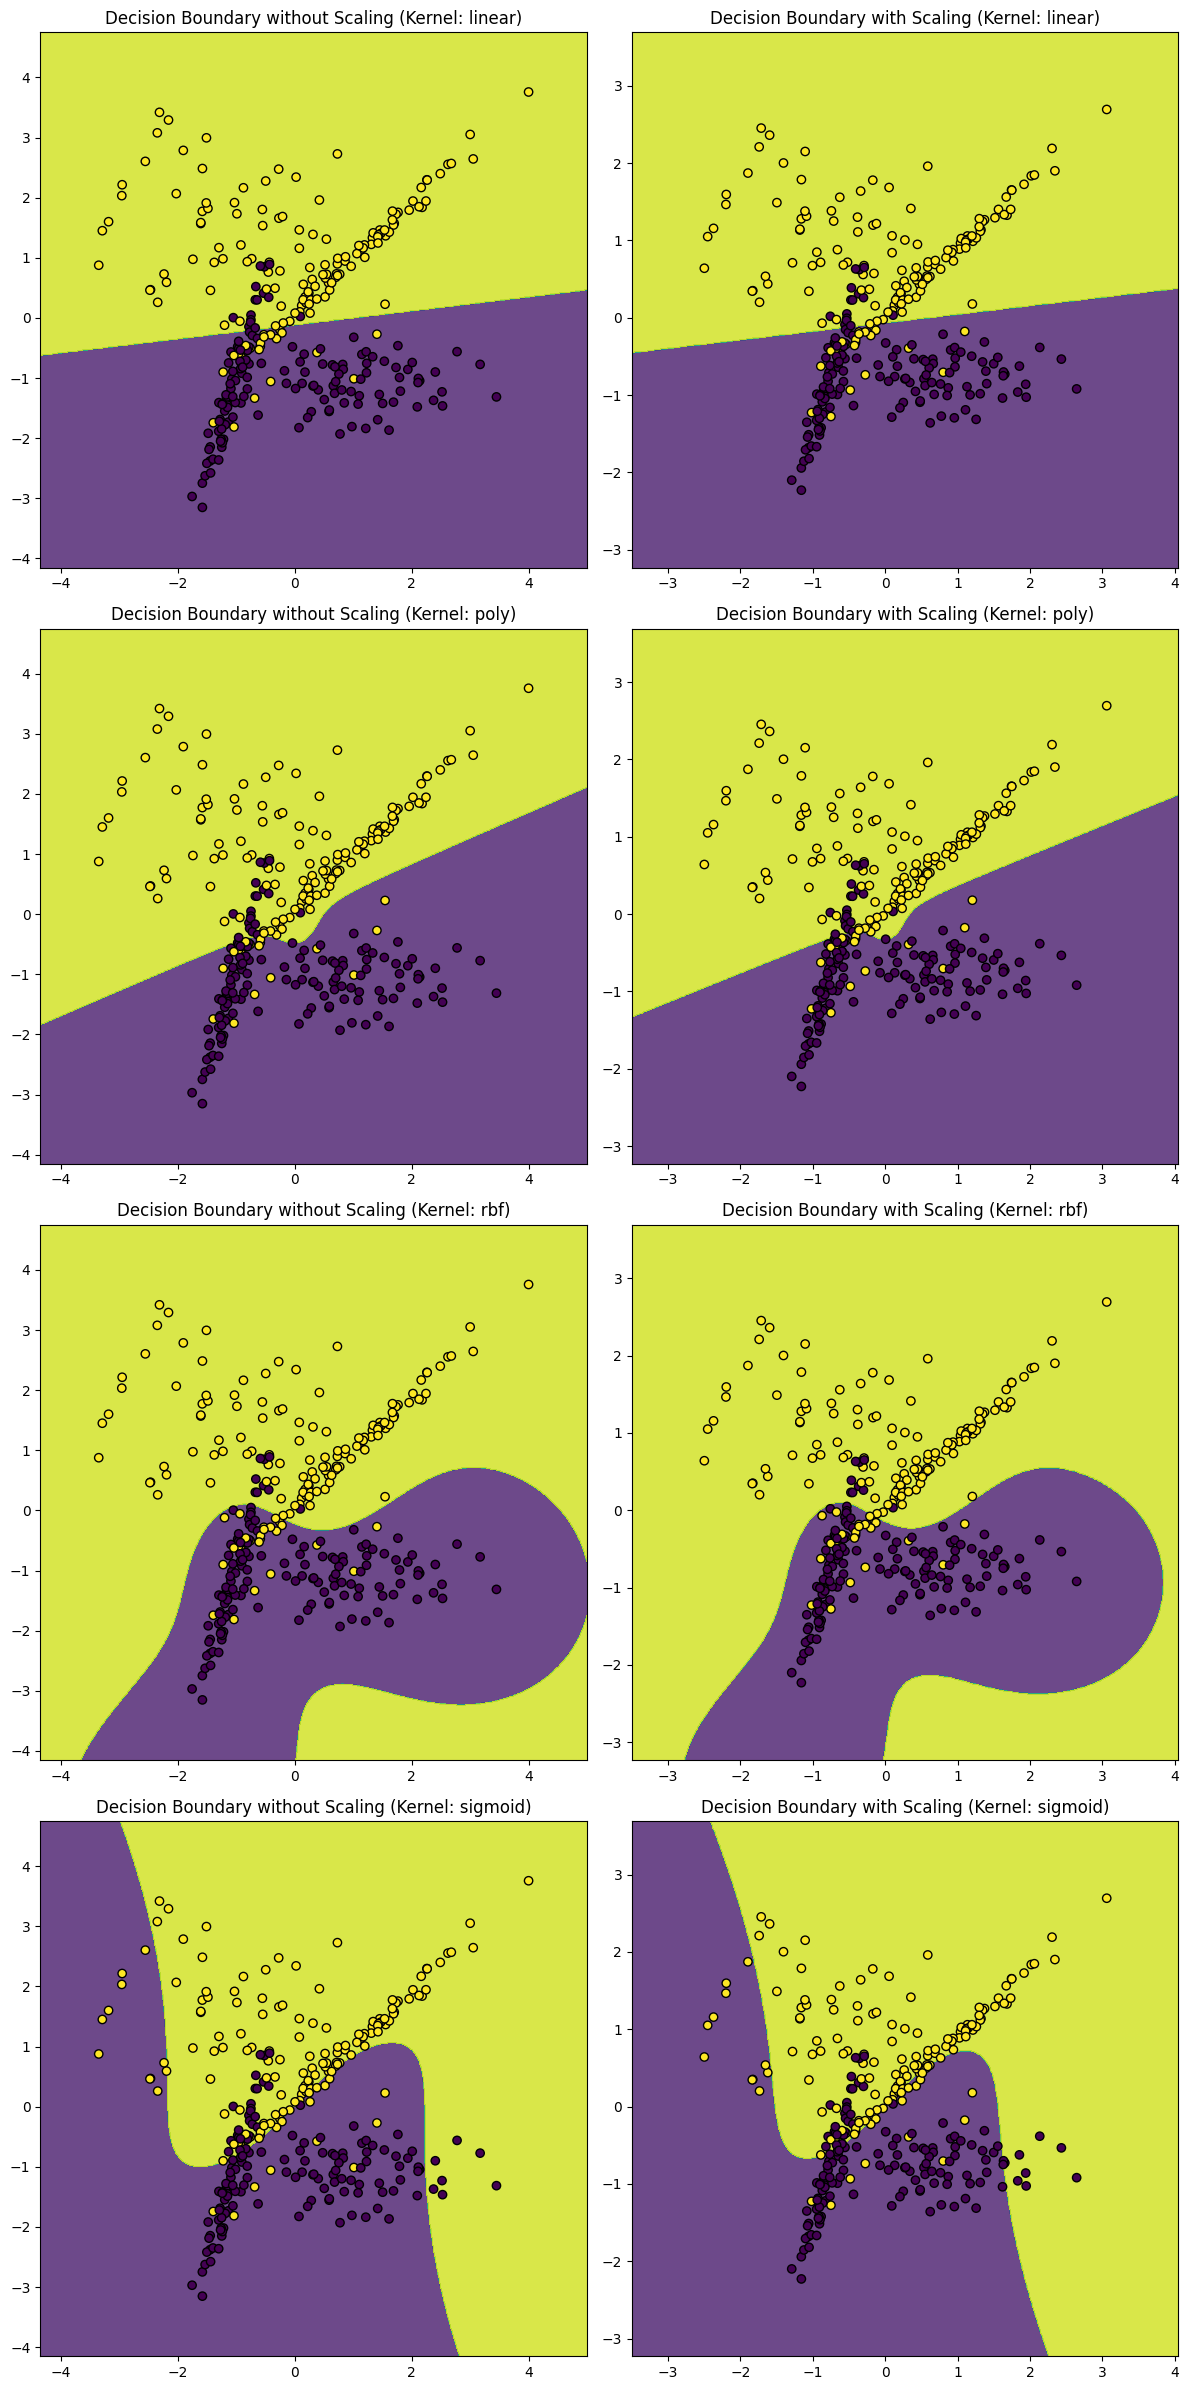

In [8]:
def plot_decision_boundary(X, y, model, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    ax.set_title(title)

fig, axs = plt.subplots(len(kernels), 2, figsize=(12, 24))

for i, kernel in enumerate(kernels):
    plot_decision_boundary(X_test, y_test, SVC(kernel=kernel, random_state=42).fit(X_train, y_train),
                           axs[i, 0], f"Decision Boundary without Scaling (Kernel: {kernel})")
    plot_decision_boundary(X_test_scaled, y_test_scaled, SVC(kernel=kernel, random_state=42).fit(X_train_scaled, y_train_scaled),
                           axs[i, 1], f"Decision Boundary with Scaling (Kernel: {kernel})")

plt.tight_layout()
plt.show()


A análise das fronteiras de decisão dos diferentes kernels do SVM (linear, polinomial, RBF e sigmoide) revela que a padronização dos dados é essencial para melhorar a eficácia dos modelos, especialmente para kernels não-lineares. Sem padronização, as fronteiras de decisão tendem a ser menos precisas e mal centradas, enquanto a padronização resulta em separações mais claras e centralizadas, permitindo que os kernels capturem melhor as complexidades nos dados.

#9. Plotagem das Curvas ROC

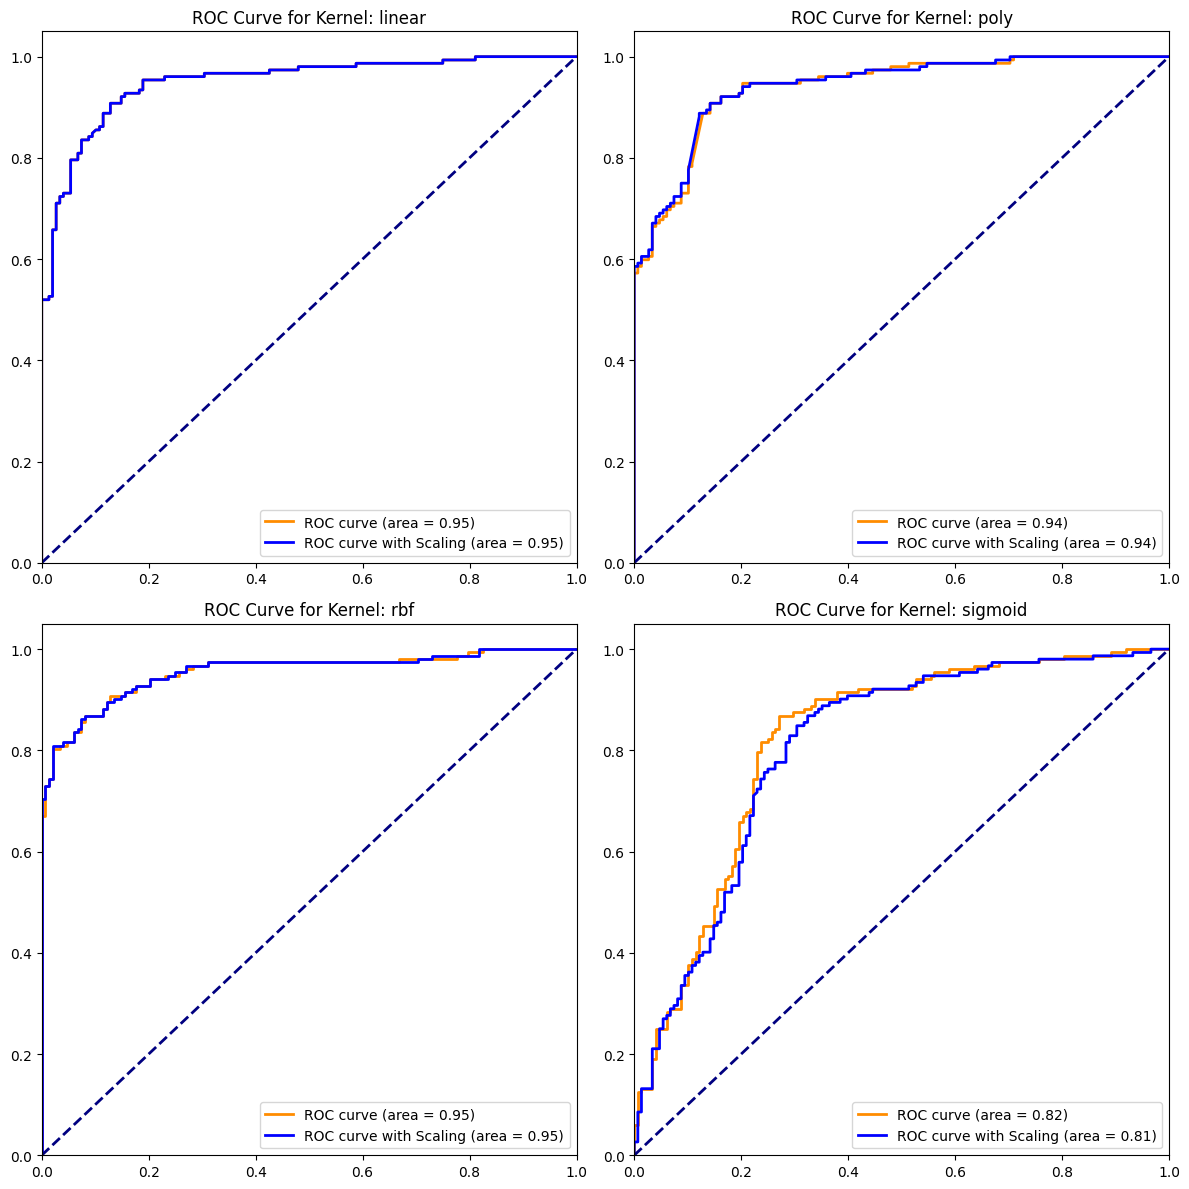

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, kernel in enumerate(kernels):
    ax = axs[i // 2, i % 2]
    fpr, tpr, _ = results[kernel]['roc_curve']
    fpr_scaled, tpr_scaled, _ = results[kernel]['roc_curve_scaled']

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % results[kernel]['auc'])
    ax.plot(fpr_scaled, tpr_scaled, color='blue', lw=2, label='ROC curve with Scaling (area = %0.2f)' % results[kernel]['auc_scaled'])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(f"ROC Curve for Kernel: {kernel}")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


Para os kernels linear e polinomial, as áreas sob a curva (AUC) são muito altas, indicando uma excelente capacidade de discriminação, e a diferença entre os modelos com e sem padronização é mínima. Para o kernel RBF, a padronização mantém uma AUC alta e estável, demonstrando que a padronização ajuda a manter o desempenho consistente. Já o kernel sigmoide apresenta a menor AUC, com ou sem padronização, indicando um desempenho inferior em relação aos outros kernels, mas a padronização ainda contribui para um desempenho um pouco mais consistente. Em resumo, a padronização tem um impacto positivo, principalmente em kernels não-lineares como RBF e sigmoide, ajudando a estabilizar e, em alguns casos, melhorar a performance.

#10. Exibição e Comparação dos Resultados

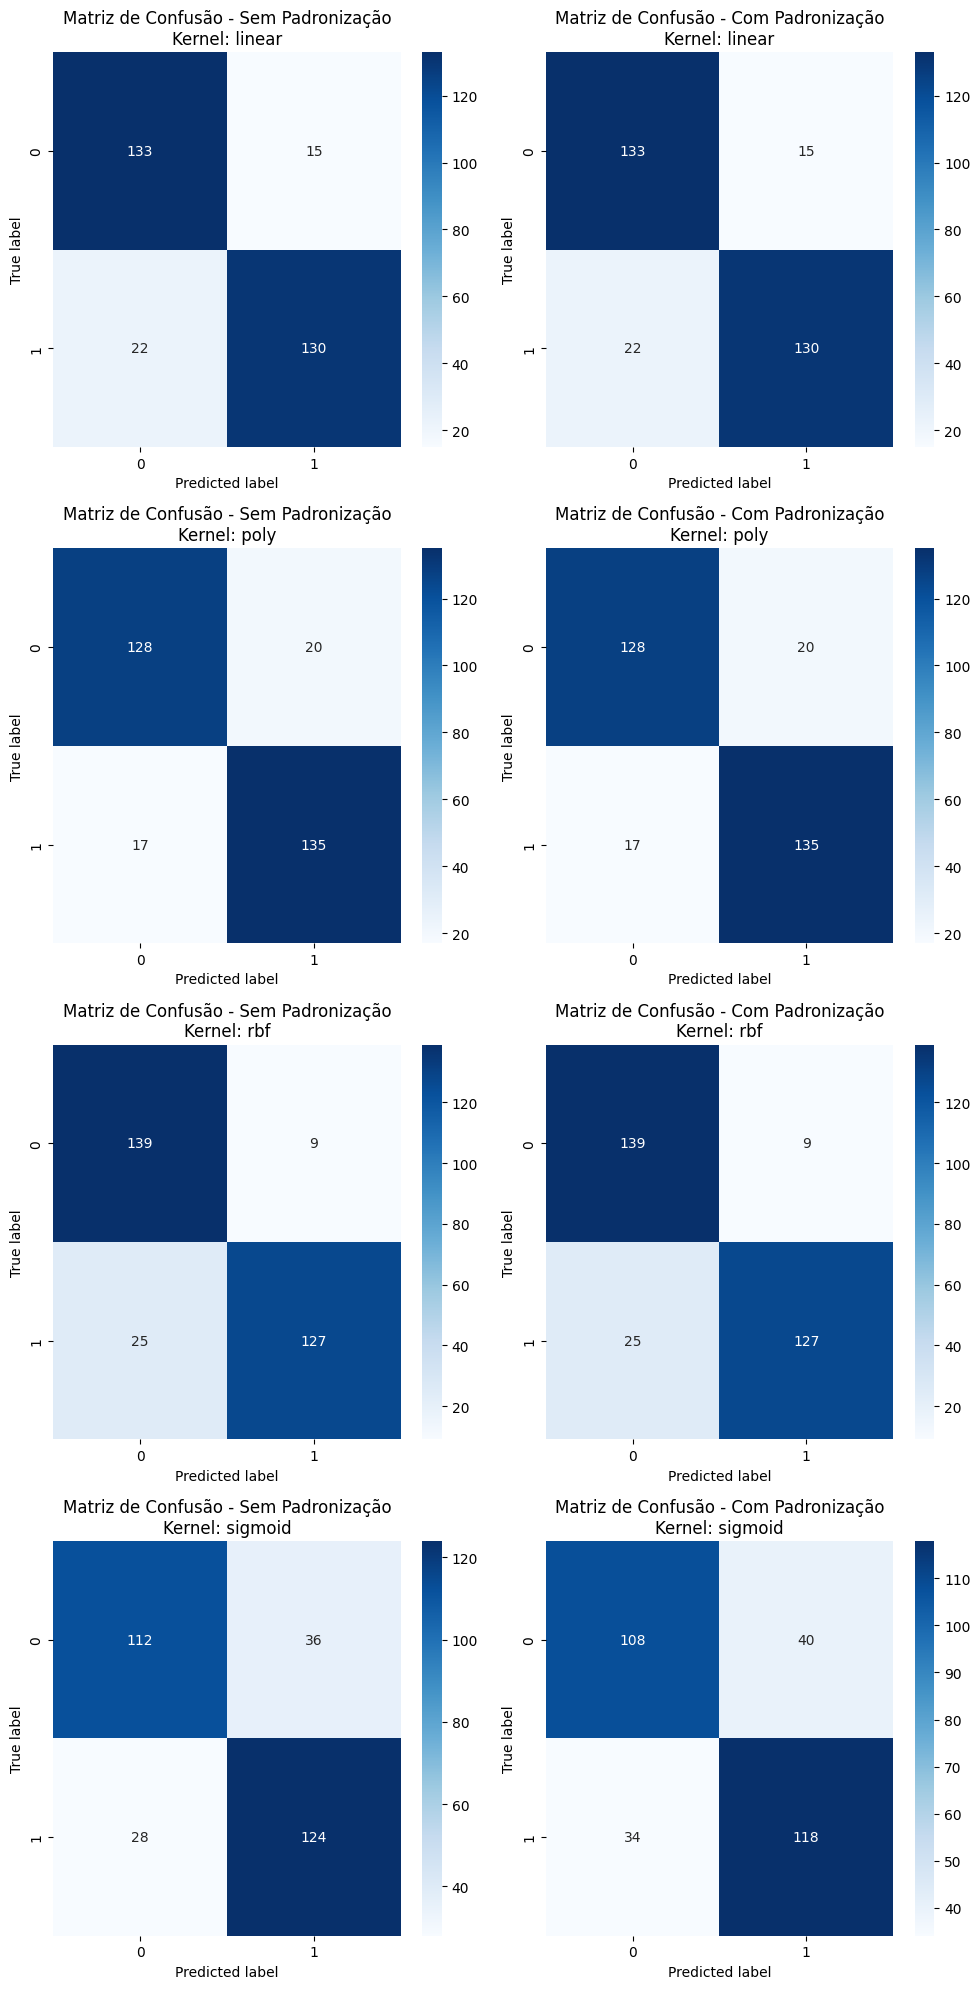

Kernel: linear
Sem Padronização
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       148
           1       0.90      0.86      0.88       152

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

Com Padronização
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       148
           1       0.90      0.86      0.88       152

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

Kernel: poly
Sem Padronização
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       148
           1       0.87      0.89      0.88       152

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88      

In [14]:
# Function to plot confusion matrix as a heatmap
def plot_confusion_matrix(cm, title, ax=None):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)

# Plotting confusion matrices for each kernel
fig, axs = plt.subplots(len(kernels), 2, figsize=(10, len(kernels) * 5))

for i, kernel in enumerate(kernels):
    # Without scaling
    plot_confusion_matrix(results[kernel]['confusion_matrix'], f"Matriz de Confusão - Sem Padronização\nKernel: {kernel}", ax=axs[i, 0])

    # With scaling
    plot_confusion_matrix(results[kernel]['confusion_matrix_scaled'], f"Matriz de Confusão - Com Padronização\nKernel: {kernel}", ax=axs[i, 1])

plt.tight_layout()
plt.show()

# Printing the classification reports for each kernel
for kernel in kernels:
    print(f"Kernel: {kernel}")
    print("Sem Padronização")
    print(results[kernel]['classification_report'])
    print("Com Padronização")
    print(results[kernel]['classification_report_scaled'])
    print("="*60)